# This is a demonstration notebook for solving inverse AFC plate problem

I will add relevant formulas here later :D

In [1]:
import jax
import jax.numpy as jnp

from jax_plate.Problem import Problem
from jax_plate.Utils import *
from jax_plate.Optimizers import optimize_trust_region, optimize_gd

%matplotlib inline
import matplotlib.pyplot as plt

### Set material parameters

The geometry, location of test point and loading function are defined in `_problem.edp`. I will change it later when we decide on the format of mesh/geometry, comfortable to the experimental guys

In [2]:
# Steel plate for Keldysh guyz
rho = 7920. # [kg/m^3]
E = 198*1e9 # [Pa]
G = 77*1e9
nu = E/(2.*G) - 1.# [1]
h = 1e-3 # [m]
D = E*h**3/(12.*(1. - nu**2))
# this value i don't know
beta = .003 # loss factor, [1]

accelerometer_params = {'radius': 4e-3, 'mass': 0.}

p = Problem("_strip.edp", h, rho, accelerometer_params)
get_afc = p.getAFCFunction(isotropic_to_full)
params = jnp.array([D, nu, beta])

RuntimeError: Resource exhausted: Out of memory while trying to allocate 2790686880 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

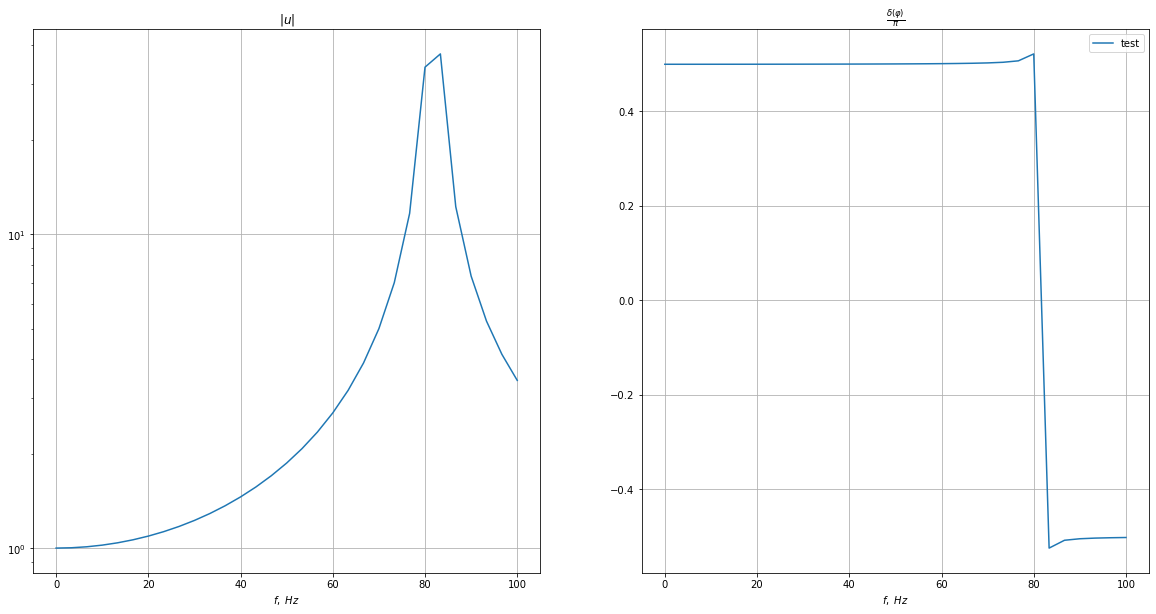

In [3]:
freqs = jnp.linspace(0, 100, 31, endpoint=True)
afc = get_afc(freqs, params)
fig, axs = plot_afc(freqs, afc, label='test')
perturbed_params = params*jnp.array([0.9, 1.1, 1.1])
loss_function = p.getMSELossFunction(isotropic_to_full, freqs, afc)
loss_and_grad = jax.value_and_grad(loss_function)
loss_and_grad(perturbed_params)

For larger grids, only a small number of frequencies can be evaluated at the GPU simultaneously without causing a JAX memory error, so they have to be evaluated in batches. ```batch_size``` parameter has to be chosen experimentally :D 

RuntimeError: Resource exhausted: Out of memory while trying to allocate 39226368 bytes.: while running replica 0 and partition 0 of a replicated computation (other replicas may have failed as well).

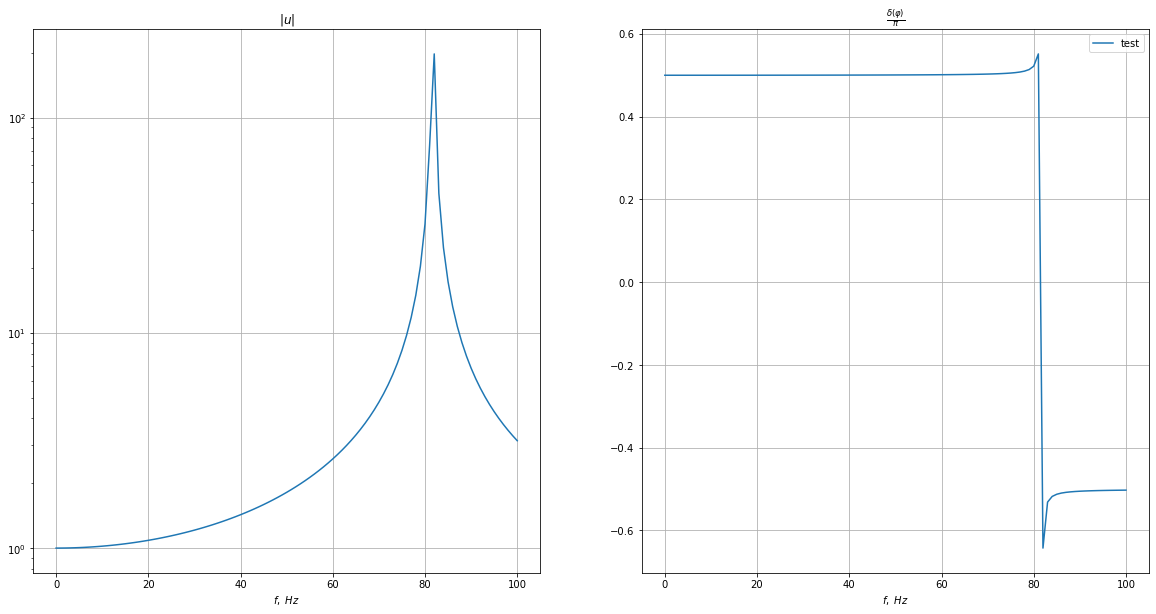

In [3]:
get_afc_batched = p.getAFCFunction(isotropic_to_full, batch_size=30)
freqs = jnp.linspace(0, 100, 101, endpoint=True)
afc = get_afc_batched(freqs, params)
fig, axs = plot_afc(freqs, afc, label='test')
perturbed_params = params*jnp.array([0.9, 1.1, 1.1])
loss_function = p.getMSELossFunction(isotropic_to_full, freqs, afc, batch_size=3)
loss_and_grad = jax.value_and_grad(loss_function)
loss_and_grad(perturbed_params)